Testing with `msprime` simulations
==

A notebook for testing `mushi`'s ability to invert data simulated under the forward model

In [1]:
import mushi

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
from scipy.special import expit
import stdpopsim

### Time grid

In [2]:
change_points = np.logspace(0, np.log10(100000), 200)
t = np.concatenate((np.array([0]), change_points))

### Define true demographic history

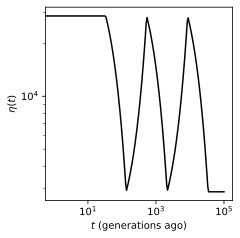

In [3]:
species = stdpopsim.get_species("HomSap")
model = species.get_demographic_model("Zigzag_1S14")
ddb = model.get_demography_debugger()
eta_true = mushi.eta(change_points,
                     1 / ddb.coalescence_rate_trajectory(steps=t,
                                                         num_samples=[2],
                                                         double_step_validation=False)[0])

plt.figure(figsize=(3.5, 3.5))
eta_true.plot(c='k');

### Mutation rate history $\mu(t)$
A 96 dimensional history with a mixture of two latent signature: constant and pulse.

/Users/williamdewitt/Applications/miniconda2/envs/mushidocs/lib/python3.7/site-packages/jax/lib/xla_bridge.py:116: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


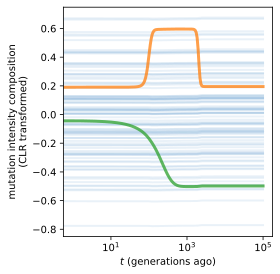

In [4]:
flat = np.ones_like(t)
pulse = expit(.1 * (t - 100)) - expit(.01 * (t - 2000))
ramp = expit(-.01 * (t - 100)) 
cols = 96
Z = np.zeros((len(t), cols))
mu0 = 1
np.random.seed(0)

Z[:, 0] = mu0 * (1 * flat + .5 * pulse)

Z[:, 1] = mu0 * (.5 * flat + .4 * ramp)

for col in range(2, cols):
    scale = np.random.lognormal(-.2, .3)
    pulse_weight = 5 if col == 0 else 0
    Z[:, col] = mu0 * scale * flat

mu_true = mushi.mu(change_points, Z)

plt.figure(figsize=(4, 4))
mu_true.plot(range(2, cols), alpha=0.1, lw=2, c='C0', clr=True)
mu_true.plot((0,), alpha=0.75, lw=3, c='C1', clr=True)
mu_true.plot((1,), alpha=0.75, lw=3, c='C2', clr=True);

Estimate the total mutation rate using $t=0$

In [5]:
mu0 = mu_true.Z[0, :].sum()
print(mu0)

83.11894862750988


## Simulate a $k$-SFS
- We'll sample 200 haplotypes
- note that this simulation will have a slightly varying total mutation rate

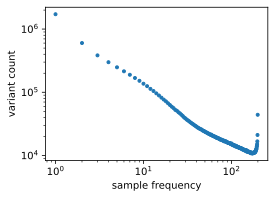

In [6]:
n = 200
ksfs = mushi.kSFS(n=n)
ksfs.simulate(eta_true, mu_true, r=0.02, seed=1)

plt.figure(figsize=(4, 3))
ksfs.plot_total(kwargs=dict(ls='', marker='.'))
plt.xscale('log')
plt.yscale('log')

plt.figure(figsize=(4, 3))
ksfs.plot(range(2, cols), clr=True, kwargs=dict(alpha=0.1, ls='', marker='.', c='C0'))
ksfs.plot((0,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='o', c='C1'))
ksfs.plot((1,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='o', c='C2'))

Number of segregating sites

In [7]:
ksfs.X.sum()

8249776

### TMRCA CDF

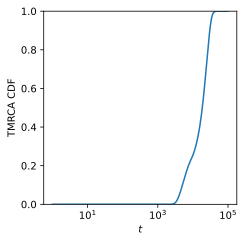

In [8]:
plt.figure(figsize=(3.5, 3.5))
plt.plot(change_points, ksfs.tmrca_cdf(eta_true))
plt.xlabel('$t$')
plt.ylabel('TMRCA CDF')
plt.ylim([0, 1])
plt.xscale('log')
plt.tight_layout()

## Inference

### convergence parameters and time grid

In [9]:
convergence = dict(tol=0, max_iter=100, trend_kwargs=dict(max_iter=10))
pts = 100

### Infer $\eta(t)$

initial objective -8.835709e+07



maximum iteration 100 reached with relative change in objective function 5.6e-07


inferred ancestral misidentification rate: 0.020


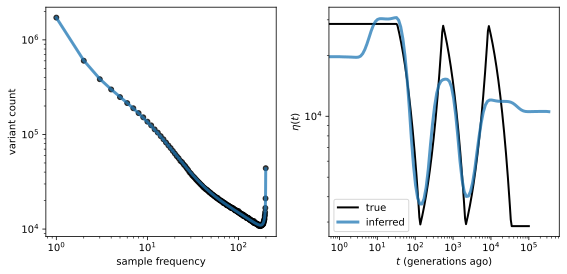

In [10]:
trend_penalties = ((0, 5e2), (2, 1e3))

folded = False

ksfs.clear_eta()
ksfs.clear_mu()
ksfs.r = None

ksfs.infer_eta(mu0,
               *trend_penalties,
               ridge_penalty=1e-4,
               pts=pts, **convergence, verbose=True, folded=folded)

if ksfs.r is not None:
    print(f'inferred ancestral misidentification rate: {ksfs.r:.3f}')

plt.figure(figsize=(8, 4))

plt.subplot(121)
ksfs.plot_total(kwargs=dict(ls='', marker='o', ms=5, c='k', alpha=0.75),
                line_kwargs=dict(c='C0', alpha=0.75, lw=3),
                fill_kwargs=dict(color='C0', alpha=0.1),
                folded=folded)
plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
eta_true.plot(c='k', lw=2, label='true')
ksfs.eta.plot(lw=3, alpha=0.75, label='inferred')
plt.legend()
plt.tight_layout()
plt.show()

### Infer $\boldsymbol\mu(t)$

initial objective -5.169483e+07



maximum iteration 100 reached with relative change in objective function 1.2e-10


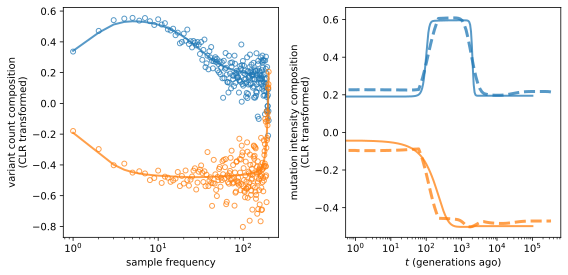

In [11]:
ksfs.clear_mu()

trend_penalties = ((0, 1e2), (1, 1e2))

ksfs.infer_mush(*trend_penalties, ridge_penalty=1e-4,
                **convergence, verbose=True)

plt.figure(figsize=(8, 4))

plt.subplot(121)
ksfs.plot((0,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='.', ms=10, mfc='none', c='C0'),
          line_kwargs=dict(alpha=0.75, lw=2, c='C0'))
ksfs.plot((1,), clr=True, kwargs=dict(alpha=0.75, ls='', marker='.', ms=10, mfc='none', c='C1'),
          line_kwargs=dict(alpha=0.75, lw=2, c='C1'))

plt.subplot(122)
mu_true.plot((0,), alpha=0.75, lw=2, c='C0', clr=True)
ksfs.mu.plot((0,), alpha=0.75, lw=3, ls='--', c='C0', clr=True)
mu_true.plot((1,), alpha=0.75, lw=2, c='C1', clr=True)
ksfs.mu.plot((1,), alpha=0.75, lw=3, ls='--', c='C1', clr=True)
plt.tight_layout()
plt.show()